In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time

In [12]:
import matplotlib as mpl
import matplotlib.pylab as plt2

plt2.rcParams["font.family"] = "NanumGothicCoding"
plt2.rcParams["font.size"] = 14
plt2.rcParams["figure.figsize"] = (12, 10)
mpl.rcParams['axes.unicode_minus'] = False

In [13]:
from skinet.utils.athena_tools import *
conn = athena_connection()
df = load_from_athena(conn, "select * from default.tm_result_temp")

...tmp_db name = tmp_20200714_17_51_09_6d4ca7169ea12d8b06f8032deee5b6147bae68da
Start creating table
drop table if exists default.tmp_20200714_17_51_09_6d4ca7169ea12d8b06f8032deee5b6147bae68da
<< table not exist

        create  table         default.tmp_20200714_17_51_09_6d4ca7169ea12d8b06f8032deee5b6147bae68da
        with (format='Parquet', parquet_compression='GZIP')
        as
        select * from default.tm_result_temp
.
>> Athena Query Success!!
>> Athena Query EXCUTION COMPLETE....
>> S3 FILE GENERATION SUCCESS!! (File count: 4)
Elapsed Time = 11.48
>> Start downloading table
aws s3 cp s3://adt-sandbox/dsc/tables/d69aaa57-46c1-40bd-ab11-617db0767202 /home/skinet/tmp/tmp_20200714_17_51_09_6d4ca7169ea12d8b06f8032deee5b6147bae68da --recursive
Elapsed Time = 3.59
>> Loading data
Dropping tmp db
<< Delete s3://adt-sandbox/dsc/tables/d69aaa57-46c1-40bd-ab11-617db0767202
Removing tmp_dir!
Elapsed Time for downloading and loading = 5.86
Total Elapsed Time = 20.93


In [14]:
df.head()

,contactid,s25csq,custid,contactstartdate,contactstarttime,contactenddate,talkenddate,contactendtime,talkendtime,userid,...,ncusttel,ncustzip,description,listid,listname,listtype,extracteddate,dialresultcd,call_success,final_success
0,81448111,211063182,211063182,2020/04/22,13:30:21,2020/04/22,2020/04/22,13:33:51,13:33:36,K1190830,...,01056947728,*,★화재실손주택(20200401)_그외 : 성공-TM거부 : [화재안심TM],123943,★화재실손주택(20200401)_그외,주택,2020/04/01,SE01,1,0
1,81295102,218106394,218106394,2020/04/13,14:51:10,2020/04/13,2020/04/13,14:53:23,14:52:34,K1190037,...,01021284991,*,★화재실손주택(20200401)_그외 : 성공-단순재통화 : [화재안심TM]목조 필...,123943,★화재실손주택(20200401)_그외,주택,2020/04/01,SS05,1,0
2,81247021,217127977,217127977,2020/04/09,16:26:43,2020/04/09,2020/04/09,16:27:05,16:26:57,CI07225,...,01022580803,*,★ADT화재안심(20200401)_일반 : 실패-무응답 : [화재안심TM],123945,★ADT화재안심(20200401)_일반,화재,2020/04/01,NF03,0,0
3,81308017,216100835,216100835,2020/04/14,09:54:27,2020/04/14,2020/04/14,09:55:19,09:55:08,K1180707,...,01044622125,*,★ADT화재안심(20200401)_일반 : 성공-거절 : [화재안심TM],123945,★ADT화재안심(20200401)_일반,화재,2020/04/01,SS03,1,0
4,81540900,219064254,219064254,2020/04/28,10:43:58,2020/04/28,2020/04/28,10:45:13,10:45:07,MPC02645,...,01062316875,*,★ADT화재안심(20200401)_일반 : 실패-무응답 : [화재안심TM],123945,★ADT화재안심(20200401)_일반,화재,2020/04/01,NF03,0,0


In [15]:
data = df.copy()

In [16]:
data[['contactstarttime', 'contactendtime']] = data[['contactstarttime', 'contactendtime']].apply(pd.to_timedelta)

In [17]:
data['call_duration'] = (data['contactendtime'] - data['contactstarttime']).astype('timedelta64[s]')

In [18]:
bins = [0, 10, 30,  60,  90, 120, 150, 180, 210, 240, 270]

In [19]:
data['call_duration_cut'] = pd.cut(data['call_duration'], bins = bins)

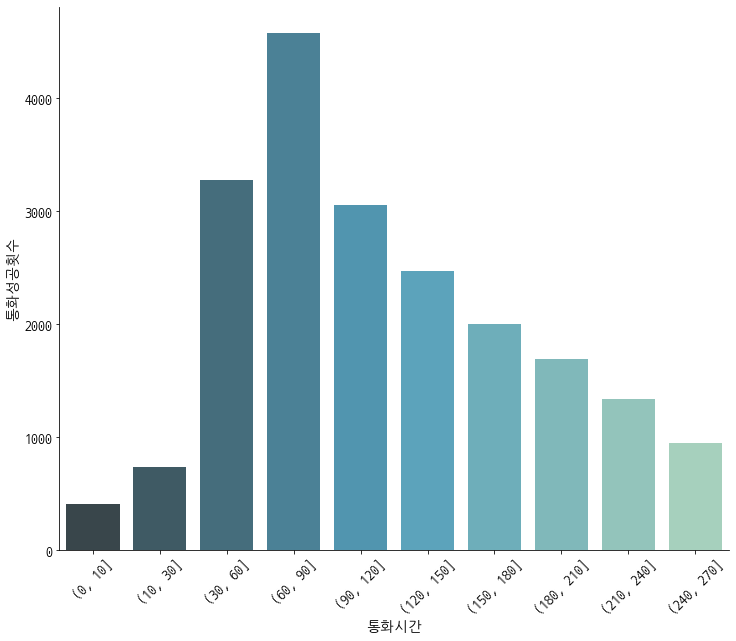

In [20]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sns.countplot(data[data['call_success'] == 1].call_duration_cut, palette = 'GnBu_d')
plt.xticks(rotation = 45)
plt.xlabel('통화시간')
plt.ylabel('통화성공횟수')
plt.savefig('통화성공건수_통화시간.png', dpi  = 500, bbox_inches = 'tight')

In [21]:
data[data['call_success'] == 1].call_duration.mean()

169.63446009008644

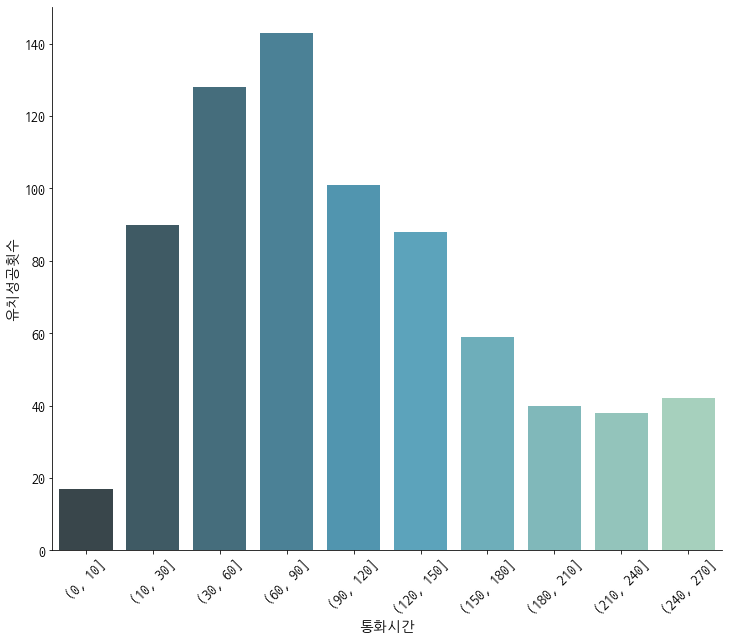

In [22]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sns.countplot(data[data['final_success'] == 1].call_duration_cut, palette = 'GnBu_d')
plt.xticks(rotation = 45)
plt.xlabel('통화시간')
plt.ylabel('유치성공횟수')
plt.savefig('유치성공건수_통화시간.png', dpi  = 500, bbox_inches = 'tight')

In [23]:
data[data['final_success'] == 1].call_duration.mean()

380.74521422060167

In [24]:
data['dialresultcd'] = data['dialresultcd'].map({
                                     'NF03' : '실패-무응답',
                                     'NF05' : '성공-가망재통화',
                                     'SE01' : '성공-TM거부',
                                     'SE04' : 'TM-자체제외',
                                     'SE05' : '오류번호',
                                     'SS01' : '성공-유치완료',
                                     'SS02' : '성공-중도취소',
                                     'SS03' : '성공-거절',
                                     'SS05' : '성공-단순재통화',
                                     'SS06' : '성공-부재중'   
                                   })

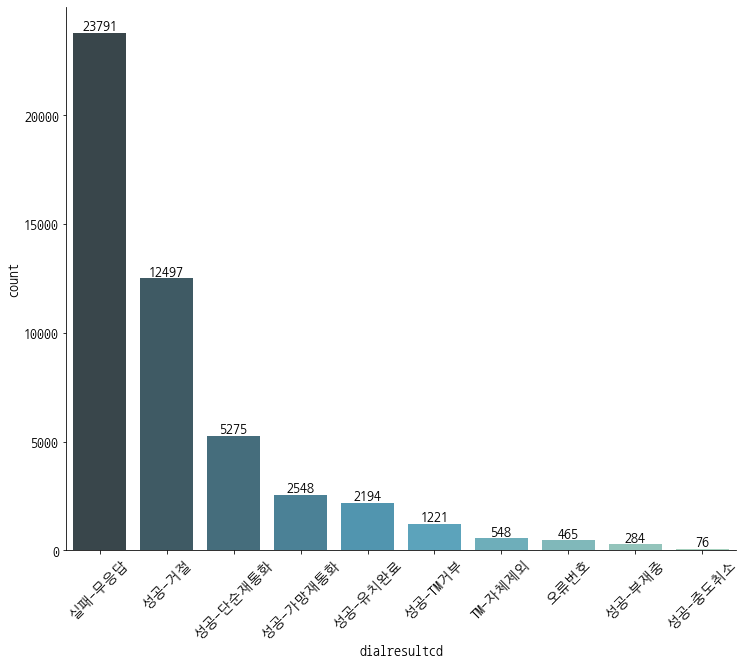

In [25]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sns.countplot(data['dialresultcd'], order = data['dialresultcd'].value_counts().index, palette = 'GnBu_d')
plt.xticks(rotation = 45)


for i, bar in enumerate(ax.patches):
    h = bar.get_height()
    ax.text(
        i, # bar index (x coordinate of text)
        h+300, # y coordinate of text
        '{}'.format(int(h)),  # y label
        ha='center', 
        va='center', 
        size=14)

plt.savefig('통화결과.png', dpi  = 500, bbox_inches = 'tight')